In [1]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1BZOv422XJvxFUnGh-0xVeSvgFgqVY45q'})

In [4]:
download.GetContentFile('train_LbELtWX.zip')
!unzip train_LbELtWX.zip

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [14]:
# loading dataset
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

#sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [24]:
# loading training images
train_img = []
for img_name in tqdm(train['id']):
    # defining the image path
    image_path = 'train/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['label'].values
print(train_x.shape)



  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 156/60000 [00:00<00:38, 1559.16it/s]

  1%|          | 322/60000 [00:00<00:37, 1587.89it/s]

  1%|          | 483/60000 [00:00<00:37, 1591.62it/s]

  1%|          | 647/60000 [00:00<00:36, 1605.05it/s]

  1%|▏         | 814/60000 [00:00<00:36, 1623.14it/s]

  2%|▏         | 978/60000 [00:00<00:36, 1627.26it/s]

  2%|▏         | 1136/60000 [00:00<00:36, 1610.34it/s]

  2%|▏         | 1292/60000 [00:00<00:36, 1592.15it/s]

  2%|▏         | 1456/60000 [00:00<00:36, 1605.34it/s]

  3%|▎         | 1621/60000 [00:01<00:36, 1616.68it/s]

  3%|▎         | 1799/60000 [00:01<00:35, 1660.47it/s]

  3%|▎         | 1977/60000 [00:01<00:34, 1692.93it/s]

  4%|▎         | 2145/60000 [00:01<00:34, 1682.46it/s]

  4%|▍         | 2313/60000 [00:01<00:34, 1679.43it/s]

  4%|▍         | 2494/60000 [00:01<00:33, 1714.23it/s]

  4%|▍         | 2666/60000 [00:01<00:33, 1711.57it/s]

  5%|▍         | 2837/60000 [00:01<00:33, 1688.19it/s]

  5%|▌   

(60000, 28, 28)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f19cc7a76d8>,
 <matplotlib.image.AxesImage at 0x7f19cc778eb8>)

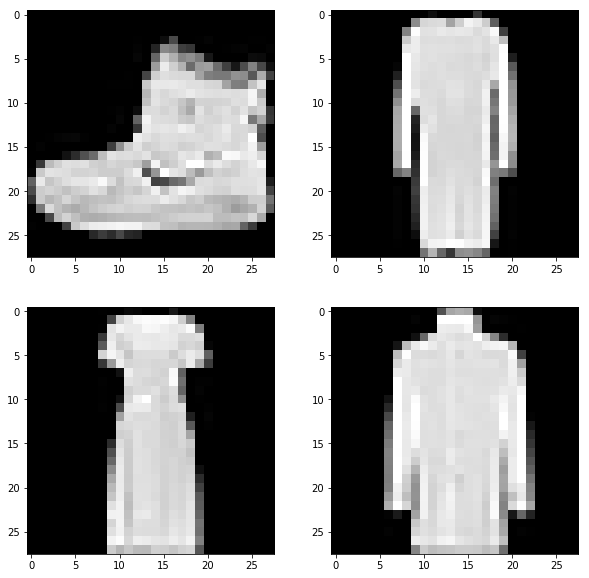

In [25]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [26]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [27]:
# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [28]:
# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [0]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [31]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [0]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [34]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.4772, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(3.6027, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(2.3297, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.5409, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.3860, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.3191, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.2527, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.0979, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(0.9660, grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(0.9005, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(0.8398, grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(0.8330, grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(0.8069, grad_fn=<NllLossBackward>)


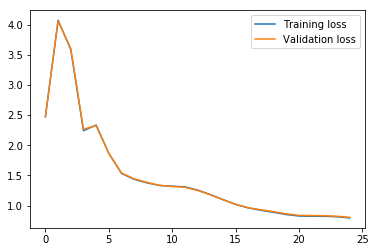

In [37]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [1]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

NameError: ignored